<a href="https://colab.research.google.com/github/wonjae124/Capston/blob/colab/Petfinder_MultiClassification_widedeep.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import os, sys
from google.colab import drive
drive.mount('/content/drive')

# my_path = '/content/notebooks'
# os.symlink('/content/drive/My Drive/Colab Notebooks/my_env', my_path) ## 소프트 link 파일 혹은 폴더를 만들 때 사용
# sys.path.insert(0, my_path)
#https://teddylee777.github.io/colab/colab%EC%97%90%EC%84%9C-python%ED%8C%A8%ED%82%A4%EC%A7%80%EB%A5%BC-permanently-%EC%9D%B8%EC%8A%A4%ED%86%A8%ED%95%98%EB%8A%94-%EB%B0%A9%EB%B2%95

!pip install --target=$my_path pytorch-widedeep
!pip install --target=$my_path git+https://github.com/jrzaurin/pytorch-widedeep.git

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
  Cloning https://github.com/jrzaurin/pytorch-widedeep.git to /tmp/pip-req-build-ym11sf3y
  Running command git clone -q https://github.com/jrzaurin/pytorch-widedeep.git /tmp/pip-req-build-ym11sf3y


In [2]:
pip install git+https://github.com/jrzaurin/pytorch-widedeep.git

  Cloning https://github.com/jrzaurin/pytorch-widedeep.git to /tmp/pip-req-build-tjn9pqxk
  Running command git clone -q https://github.com/jrzaurin/pytorch-widedeep.git /tmp/pip-req-build-tjn9pqxk


In [ ]:
# !git clone https://github.com/jrzaurin/pytorch-widedeep
# !cd pytorch-widedeep

fatal: destination path 'pytorch-widedeep' already exists and is not an empty directory.


In [ ]:
# !pip install -e .


ERROR: File "setup.py" or "setup.cfg" not found. Directory cannot be installed in editable mode: /content


In [279]:
import pandas as pd
import numpy as np
import torch
import time
from io import StringIO

from sklearn.model_selection import train_test_split

from pytorch_widedeep import Trainer
from pytorch_widedeep.preprocessing import WidePreprocessor, TabPreprocessor
from pytorch_widedeep.models import Wide, TabMlp, WideDeep
from pytorch_widedeep.metrics import Accuracy, Precision, Recall, F1Score
from torchmetrics import AUROC
#from torchmetrics import Accuracy, AUROC, Precision, Recall, F1Score #AUROC가 뭐지? #wide_deep의 metric을 안 썼다!!
from pytorch_widedeep.initializers import XavierNormal
from pytorch_widedeep.utils import LabelEncoder
from torch.optim import SGD, lr_scheduler
import seaborn as sns
pd.set_option("display.max_columns", 200)
pd.set_option("display.max_rows", 300)

In [280]:
df = pd.read_csv('/content/drive/MyDrive/Wide_deep/train_0406.csv') #  index_col=[0],
df.drop(df.filter(regex="Unname"),axis=1, inplace=True)
df = df.fillna('?')
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14993 entries, 0 to 14992
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Type           14993 non-null  object
 1   Name           14993 non-null  object
 2   Age            14993 non-null  int64 
 3   Breed1         14993 non-null  object
 4   Breed2         14993 non-null  object
 5   Gender         14993 non-null  object
 6   Color1         14993 non-null  object
 7   Color2         14993 non-null  object
 8   Color3         14993 non-null  object
 9   MaturitySize   14993 non-null  object
 10  FurLength      14993 non-null  object
 11  Vaccinated     14993 non-null  object
 12  Dewormed       14993 non-null  object
 13  Sterilized     14993 non-null  object
 14  Health         14993 non-null  object
 15  Quantity       14993 non-null  int64 
 16  Fee            14993 non-null  int64 
 17  Description    14993 non-null  object
 18  PetID          14993 non-n

In [281]:
df.head()

,Type,Name,Age,Breed1,Breed2,Gender,Color1,Color2,Color3,MaturitySize,FurLength,Vaccinated,Dewormed,Sterilized,Health,Quantity,Fee,Description,PetID,AdoptionSpeed,DataType
0,Cat,Nibble,3,Tabby,0,Male,Black,White,?,Small,Short,No,No,No,Healthy,1,100,Nibble is a 3+ month old ball of cuteness. He ...,86e1089a3,2,train
1,Cat,?,1,Domestic medium hair,0,Male,Black,Brown,?,Medium,Medium,Not sure,Not sure,Not sure,Healthy,1,0,I just found it alone yesterday near my apartm...,6296e909a,0,train
2,Dog,Brisco,1,Mixed breeds,0,Male,Brown,White,?,Medium,Medium,Yes,Yes,No,Healthy,1,0,Their pregnant mother was dumped by her irresp...,3422e4906,3,train
3,Dog,Miko,4,Mixed breeds,0,Female,Black,Brown,?,Medium,Short,Yes,Yes,No,Healthy,1,150,"Good guard dog, very alert, active, obedience ...",5842f1ff5,2,train
4,Dog,Hunter,1,Mixed breeds,0,Male,Black,?,?,Medium,Short,No,No,No,Healthy,1,0,This handsome yet cute boy is up for adoption....,850a43f90,2,train


In [282]:
df['AdoptionSpeed'].value_counts()

4    4197
2    4037
3    3259
1    3090
0     410
Name: AdoptionSpeed, dtype: int64

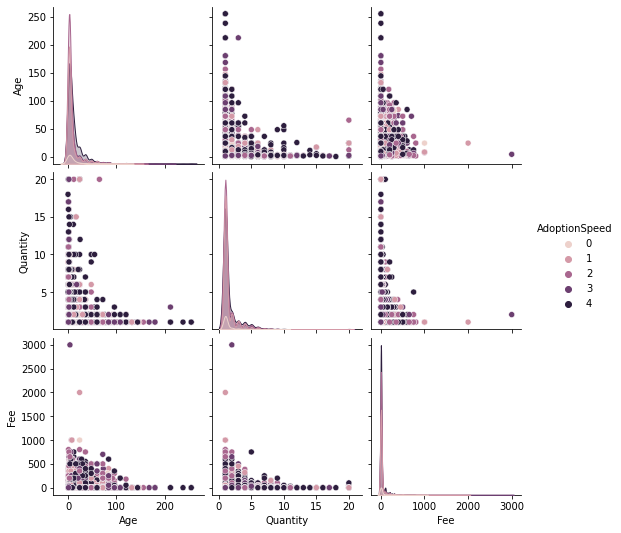

In [283]:
sns.pairplot(df,hue = 'AdoptionSpeed')

In [284]:
encoder = LabelEncoder(["AdoptionSpeed"])
df_enc = encoder.fit_transform(df)
df_enc["AdoptionSpeed"] = df_enc["AdoptionSpeed"] - 1

In [285]:
df_enc.head()

,Type,Name,Age,Breed1,Breed2,Gender,Color1,Color2,Color3,MaturitySize,FurLength,Vaccinated,Dewormed,Sterilized,Health,Quantity,Fee,Description,PetID,AdoptionSpeed,DataType
0,Cat,Nibble,3,Tabby,0,Male,Black,White,?,Small,Short,No,No,No,Healthy,1,100,Nibble is a 3+ month old ball of cuteness. He ...,86e1089a3,0,train
1,Cat,?,1,Domestic medium hair,0,Male,Black,Brown,?,Medium,Medium,Not sure,Not sure,Not sure,Healthy,1,0,I just found it alone yesterday near my apartm...,6296e909a,1,train
2,Dog,Brisco,1,Mixed breeds,0,Male,Brown,White,?,Medium,Medium,Yes,Yes,No,Healthy,1,0,Their pregnant mother was dumped by her irresp...,3422e4906,2,train
3,Dog,Miko,4,Mixed breeds,0,Female,Black,Brown,?,Medium,Short,Yes,Yes,No,Healthy,1,150,"Good guard dog, very alert, active, obedience ...",5842f1ff5,0,train
4,Dog,Hunter,1,Mixed breeds,0,Male,Black,?,?,Medium,Short,No,No,No,Healthy,1,0,This handsome yet cute boy is up for adoption....,850a43f90,0,train


In [286]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14993 entries, 0 to 14992
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Type           14993 non-null  object
 1   Name           14993 non-null  object
 2   Age            14993 non-null  int64 
 3   Breed1         14993 non-null  object
 4   Breed2         14993 non-null  object
 5   Gender         14993 non-null  object
 6   Color1         14993 non-null  object
 7   Color2         14993 non-null  object
 8   Color3         14993 non-null  object
 9   MaturitySize   14993 non-null  object
 10  FurLength      14993 non-null  object
 11  Vaccinated     14993 non-null  object
 12  Dewormed       14993 non-null  object
 13  Sterilized     14993 non-null  object
 14  Health         14993 non-null  object
 15  Quantity       14993 non-null  int64 
 16  Fee            14993 non-null  int64 
 17  Description    14993 non-null  object
 18  PetID          14993 non-n

In [287]:
df_enc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14993 entries, 0 to 14992
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Type           14993 non-null  object
 1   Name           14993 non-null  object
 2   Age            14993 non-null  int64 
 3   Breed1         14993 non-null  object
 4   Breed2         14993 non-null  object
 5   Gender         14993 non-null  object
 6   Color1         14993 non-null  object
 7   Color2         14993 non-null  object
 8   Color3         14993 non-null  object
 9   MaturitySize   14993 non-null  object
 10  FurLength      14993 non-null  object
 11  Vaccinated     14993 non-null  object
 12  Dewormed       14993 non-null  object
 13  Sterilized     14993 non-null  object
 14  Health         14993 non-null  object
 15  Quantity       14993 non-null  int64 
 16  Fee            14993 non-null  int64 
 17  Description    14993 non-null  object
 18  PetID          14993 non-n

In [288]:
df_train, df_valid = train_test_split(df_enc, test_size = 0.2, stratify = df_enc["AdoptionSpeed"], random_state = 1)
df_valid, df_test = train_test_split(df_valid, test_size = 0.5, stratify = df_valid["AdoptionSpeed"], random_state = 1)

In [289]:
print(len(df_train))
print(len(df_valid))
print(len(df_test))

11994
1499
1500


In [290]:
wide_cols = [
             "Type",
             "Name",
             "Breed1",
             "Color1",
             "Health", 
             "Vaccinated",
             "Dewormed",                        
] #wide part는 memorization 담당(고정요소. 타고 태어난 요소)

In [307]:
crossed_cols = [("Vaccinated","Health"),("Dewormed","Health")] # 얼만큼 가중치를 줄지 정할 수 있다.

cat_embed_cols = [   
             "Type",                   
             "MaturitySize",                  
             "Health",   
             "Breed1",               
             "Color1",                              
             "Name",                  
             "Dewormed",                  
             "Sterilized",                    
             "Gender",         
             "FurLength",
             "Vaccinated",
]  # deep part는 Generalization 담당(고정요소 + 변동 요소)

continuous_cols = ["Fee","Age"] 

target = 'AdoptionSpeed' 
target = df_enc[target].values

In [308]:
wide_preprocessor = WidePreprocessor(wide_cols = wide_cols, crossed_cols = crossed_cols) #????
X_wide_tr = wide_preprocessor.fit_transform(df_train) # 왜이렇게 많이 뭔가 전처리 하지?
X_wide_val = wide_preprocessor.fit_transform(df_valid) 
X_wide_test = wide_preprocessor.fit_transform(df_test) 



tab_preprocessor = TabPreprocessor(
    cat_embed_cols = cat_embed_cols, continuous_cols= continuous_cols, scale = True
)

X_tab_tr = tab_preprocessor.fit_transform(df_train)
X_tab_val = tab_preprocessor.fit_transform(df_valid)
X_tab_test = tab_preprocessor.fit_transform(df_test)

y_train = df_train["AdoptionSpeed"].values
y_vaild = df_valid["AdoptionSpeed"].values
y_test = df_test["AdoptionSpeed"].values

X_train = {'X_wide' : X_wide_tr, 'X_tab' : X_tab_tr, "target" : y_train}
X_val = {'X_wide':X_wide_val, 'X_tab' : X_tab_val, "target" : y_vaild}

In [309]:
X_wide.shape

(11994, 9)

In [310]:
model

WideDeep(
  (wide): Wide(
    (wide_linear): Embedding(7701, 5, padding_idx=0)
  )
  (deeptabular): TabMlp(
    (cat_and_cont_embed): DiffSizeCatAndContEmbeddings(
      (cat_embed): DiffSizeCatEmbeddings(
        (embed_layers): ModuleDict(
          (emb_layer_Type): Embedding(3, 2, padding_idx=0)
          (emb_layer_MaturitySize): Embedding(5, 3, padding_idx=0)
          (emb_layer_Health): Embedding(4, 3, padding_idx=0)
          (emb_layer_Breed1): Embedding(90, 20, padding_idx=0)
          (emb_layer_Color1): Embedding(8, 5, padding_idx=0)
          (emb_layer_Name): Embedding(1179, 84, padding_idx=0)
          (emb_layer_Dewormed): Embedding(4, 3, padding_idx=0)
          (emb_layer_Sterilized): Embedding(4, 3, padding_idx=0)
          (emb_layer_Gender): Embedding(4, 3, padding_idx=0)
          (emb_layer_FurLength): Embedding(4, 3, padding_idx=0)
          (emb_layer_Vaccinated): Embedding(4, 3, padding_idx=0)
        )
        (embedding_dropout): Dropout(p=0.1, inplace=Fals

#Define the model

In [328]:
wide = Wide(input_dim=np.unique(X_train['X_wide']).shape[0], pred_dim = df_enc["AdoptionSpeed"].nunique()) #TODO. pred_dim을 multi_classification에서는 내가 사용할 class 개수로 바꾸는건가?....

deeptabular = TabMlp(
    column_idx = tab_preprocessor.column_idx,
    cat_embed_input = tab_preprocessor.cat_embed_input,
    cat_embed_dropout=0.1,
    continuous_cols = tab_preprocessor.continuous_cols,
    mlp_hidden_dims=[400, 200],
    mlp_dropout=0.5,
    mlp_activation="leaky_relu",    
)

target_col = "AdoptionSpeed"
target = df_train[target_col].values

model = WideDeep(wide = wide, 
                 deeptabular = deeptabular,
                 head_hidden_dims = [200,100],
                 pred_dim = df_enc["AdoptionSpeed"].nunique())
model

WideDeep(
  (wide): Wide(
    (wide_linear): Embedding(7701, 5, padding_idx=0)
  )
  (deeptabular): TabMlp(
    (cat_and_cont_embed): DiffSizeCatAndContEmbeddings(
      (cat_embed): DiffSizeCatEmbeddings(
        (embed_layers): ModuleDict(
          (emb_layer_Type): Embedding(3, 2, padding_idx=0)
          (emb_layer_MaturitySize): Embedding(5, 3, padding_idx=0)
          (emb_layer_Health): Embedding(4, 3, padding_idx=0)
          (emb_layer_Breed1): Embedding(90, 20, padding_idx=0)
          (emb_layer_Color1): Embedding(8, 5, padding_idx=0)
          (emb_layer_Name): Embedding(1179, 84, padding_idx=0)
          (emb_layer_Dewormed): Embedding(4, 3, padding_idx=0)
          (emb_layer_Sterilized): Embedding(4, 3, padding_idx=0)
          (emb_layer_Gender): Embedding(4, 3, padding_idx=0)
          (emb_layer_FurLength): Embedding(4, 3, padding_idx=0)
          (emb_layer_Vaccinated): Embedding(4, 3, padding_idx=0)
        )
        (embedding_dropout): Dropout(p=0.1, inplace=Fals

In [329]:
tab_preprocessor.embed_dim

{'Breed1': 20,
 'Color1': 5,
 'Dewormed': 3,
 'FurLength': 3,
 'Gender': 3,
 'Health': 3,
 'MaturitySize': 3,
 'Name': 84,
 'Sterilized': 3,
 'Type': 2,
 'Vaccinated': 3}

In [330]:
tab_preprocessor.column_idx

{'Age': 12,
 'Breed1': 3,
 'Color1': 4,
 'Dewormed': 6,
 'Fee': 11,
 'FurLength': 9,
 'Gender': 8,
 'Health': 2,
 'MaturitySize': 1,
 'Name': 5,
 'Sterilized': 7,
 'Type': 0,
 'Vaccinated': 10}

In [331]:
np.unique(X_wide).shape[0]

7700

In [332]:
wide_preprocessor.wide_dim

1303

In [333]:
wide

Wide(
  (wide_linear): Embedding(7701, 5, padding_idx=0)
)

In [346]:
auroc = AUROC(num_classes=df_enc["AdoptionSpeed"].nunique())

/usr/local/lib/python3.7/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)


In [335]:
wide_opt = SGD(model.wide.parameters(), lr=0.1)
deep_opt = SGD(model.deeptabular.parameters(), lr = 0.1)
head_opt = SGD(model.deephead.parameters(), lr = 0.1)


wide_sch = lr_scheduler.StepLR(wide_opt, step_size = 3)
deep_sch = lr_scheduler.StepLR(deep_opt, step_size = 3)
head_sch = lr_scheduler.StepLR(head_opt, step_size = 3)


optimizers = {
    "wide":wide_opt,
    "deeptabular":deep_opt,
    "deephead": head_opt,   
}

schedulers = {
    "wide":wide_sch,
    "deeptabular":deep_sch,
    "deephead": head_sch,
}

initializers = {
    "wide":XavierNormal,
    "deeptabular":XavierNormal
}

In [336]:
deep_opt

SGD (
Parameter Group 0
    dampening: 0
    initial_lr: 0.1
    lr: 0.1
    momentum: 0
    nesterov: False
    weight_decay: 0
)

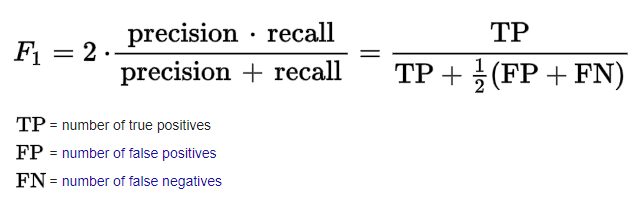 

출처 : https://for-my-wealthy-life.tistory.com/6 

In [355]:
# deep_sch = lr_scheduler.StepLR(deep_opt, step_size = 3)
trainer = Trainer (
    model,
    objective = "multiclass",
    lr_schedular = schedulers,
    initializers = initializers, #내가 이걸 왜 썼지?
    optimizers = optimizers,
    metrics = [Precision, Recall, F1Score],
)


/usr/local/lib/python3.7/dist-packages/pytorch_widedeep/initializers.py:35: UserWarning: No initializer found for deephead
  "No initializer found for {}".format(name), UserWarning


In [356]:
trainer.fit(X_train = X_train,
            X_val = X_val,
            n_epochs = 5,
            batch_size = 2)

epoch 1:  13%|█▎        | 752/5997 [00:13<01:37, 53.76it/s, loss=1.53, metrics={'prec': 0.2258, 'rec': 0.2306, 'f1': 0.2244}]


IndexError: ignored

In [ ]:

start = time.time()


trainer.fit(
    X_wide=wide,
    X_tab = X_tab,
    target = target,
    n_epochs = 50,
    batch_size = 256,
)

end = time.time()
total_time = (end-start)/60

print("excution_time : {:.1f}min".format(total_time))

In [ ]:
#trainer와 torch는 무슨 차이지?
# Option 1: this will also save training history and lr history if the

trainer.save(path="model_weights", save_state_dict = True)

# Option 2: save as any other torch model

torch.save(model.state_dict(), "model_weights/wd_model.pt") # 이게 도대체 뭐야? 허허... 왜 파일 확장자가 pt인거지?

model_new = WideDeep(wide = wide, deeptabular = tab_mlp) # wide랑 tab_mlp랑 왜 따로 트랜스폼 해두었을까?

model_new.load_state_dict(torch.load("model_weights/wd_model.pt")) 

trainer_new = Trainer(model_new, objective = 'binary') #trainer는 언제 만들어서 언제 활용했지?

preds = trainer_new.predict(X_wide=X_wide, X_tab = X_tab)

In [ ]:
!pytest tests